# Vector Reflectivity Equation Comparison

This notebook compares the forward and adjoint operators of different forms of the vector reflectivity based acoustic wave equation.

In [135]:
import numpy as np
from devito import *
from examples.seismic import setup_geometry, demo_model, RickerSource, Receiver, plot_velocity, plot_shotrecord

# Plotting
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sympy import latex
from IPython.display import Latex

## Source and receivers creators


In [136]:
# Function to create sources and receivers
def src_rec(model, geometry, src_pos, rec_depth, nrec):
    src = RickerSource(name='src', grid=model.grid, f0=geometry.f0, 
                       time_range=geometry.time_axis)

    rec = Receiver(name='rec', grid=model.grid, npoint=nrec,
                   time_range=geometry.time_axis)

    src.coordinates.data[:, 0] = src_pos[0]
    src.coordinates.data[:, 1] = src_pos[1]
    rec.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=nrec)
    rec.coordinates.data[:, 1] = rec_depth
    
    return src, rec


# Function to create adjoint sources
def adjoint_src(model, geometry, src_pos):
    srca = Receiver(name='srca', grid=model.grid,
                    time_range=geometry.time_axis,
                    npoint=1)

    srca.coordinates.data[:, 0] = src_pos[0]
    srca.coordinates.data[:, 1] = src_pos[1]

    return srca

## Acquisition geometry and model

In [137]:
# Parameters

NX = 101
NZ = 101

SHAPE = (NX, NZ)
SPACING = (5, 5)
NLAYERS = 2
SPACE_ORDER = 2
TIME_ORDER = 2
DTYPE = np.float64
NBL = 50

preset_params = {
    'layers-viscoacoustic': {
        'nlayers': NLAYERS, 'shape': SHAPE, 'spacing': SPACING,
        'space_order': SPACE_ORDER, 'dtype': DTYPE,# 'nbl': NBL
    },
    'layers-isotropic': {
        'nlayers': NLAYERS, 'shape': SHAPE,# 'b': np.ones(SHAPE),
        'spacing': SPACING, 'space_order': SPACE_ORDER, 'dtype': DTYPE,
        #'nbl': NBL
    },
}

preset = 'layers-isotropic'

In [138]:
model = demo_model(preset, **preset_params[preset])

Operator `initdamp` ran in 0.01 s


In [139]:
divr = Function(name='divr', grid=model.grid, space_order = SPACE_ORDER)
Operator([Eq(divr, div(model.r))])()

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=2.6e-05, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

Data(0.02666667)

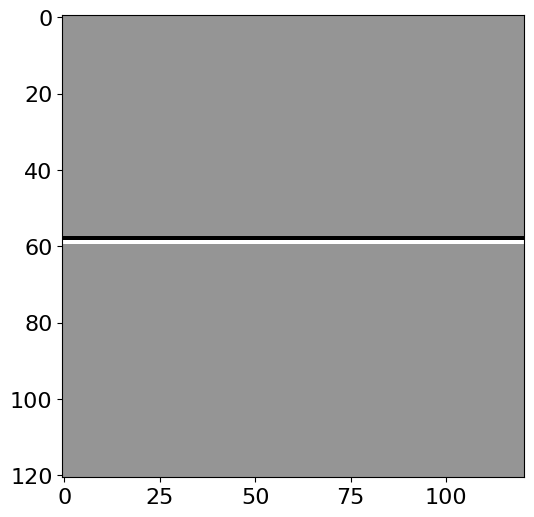

In [140]:
plt.imshow(divr.data.T, cmap='Greys')
np.max(divr.data)

In [141]:
tn = 700
f0 = 0.020
# max_dt = (np.max(model.vp.data * 1e3)*(1/SPACING[0]**2 + 1/SPACING[1]**2 - np.min(divr.data)/2)**.5)**-1
# dt = 0.9*max_dt
dt = model.critical_dt

geometry = setup_geometry(model, tn, f0)
geometry.resample(dt)

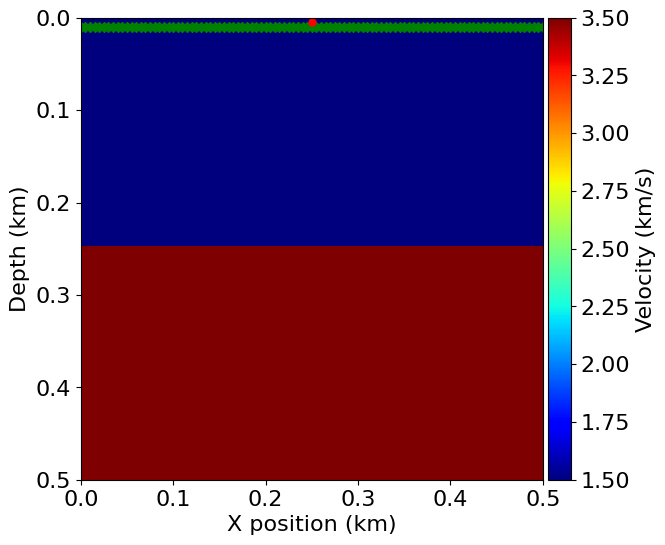

In [142]:
plot_velocity(model, geometry.src_positions, geometry.rec_positions)

## Operators

In [143]:
class OpWrapper():
    def __init__(self, forward, adjoint):
        self.forward = forward
        self.adjoint = adjoint

    def __call__(self, model, geometry, src, rec, **kwargs):
        return self.forward(model, geometry, src, rec, **kwargs)
    
    def T(self, model, geometry, rec, srca=None, **kwargs):
        return self.adjoint(model, geometry, rec, srca, **kwargs)

### Modified

The modified equation currently being used.

- Foward:

    $$
        m \frac{\partial^2 u}{\partial t^2} - \frac{1}{v_p} \nabla \cdot (v_p \nabla u) + 2\nabla \cdot(u\mathbf{R}) - 2u \nabla \cdot \mathbf{R} = S
    $$

- Backward:

    $$
        m\frac{\partial^2 v}{\partial dt} - \nabla \cdot \left[ v_p \nabla\left( \frac{1}{v_p} v \right) \right] + 2 \mathbf{R} \cdot \nabla v - 2v \nabla \cdot \mathbf{R} = R
    $$

In [144]:
def forward(model, geometry, src, rec):
    u = TimeFunction(name='u', grid=model.grid, time_order=TIME_ORDER,
                            space_order=SPACE_ORDER)

    m = model.m
    r = model.r
    vp = model.vp
    dt = model.grid.stepping_dim.spacing

    pde = m * u.dt2 - 1/vp * div(vp*grad(u, .5), -.5) + 2 * div(u * r, -.5)\
          + 2 * u * div(-r, -.5) + model.damp * u.dt
    stencil = [Eq(u.forward, solve(pde, u.forward))]

    src_term = src.inject(field=u.forward, expr=src * dt**2/model.m)
    rec_term = rec.interpolate(expr=u)

    op = Operator(stencil + src_term + rec_term, subs=model.spacing_map)
    op(dt=geometry.dt)
    
    return u


def adjoint(model, geometry, rec, srca=None):
    v = TimeFunction(name='v', grid=model.grid, time_order=TIME_ORDER,
                    space_order=SPACE_ORDER)
    
    m = model.m
    vp = model.vp
    r = model.r
    dt = model.grid.stepping_dim.spacing

    pde = m * v.dt2 - div(vp * grad(v/vp, .5), -.5) - 2 * r.T * grad(v, .5)\
        - 2 * v * div(r, -.5) + model.damp * v.dt.T
    stencil = [Eq(v.backward, solve(pde, v.backward))]

    rec_term = rec.inject(v.backward, expr = rec * dt**2 / m)

    terms = stencil
    terms += rec_term

    if srca:
        srca_term = srca.interpolate(expr=v)
        terms += srca_term

    op = Operator(terms, subs=model.spacing_map)
    op(dt=geometry.dt)
    return v

L_modified = OpWrapper(forward, adjoint)

### Original

The original equation presented in the paper by [Whitmore et al. (2020)](https://doi.org/10.1190/segam2020-3424516.1), but multiplied by $m = \dfrac{1}{v_p^2}$

- Forward:

    $$
        m\frac{\partial^2 u}{\partial t^2} - \left[ \nabla^2u + \frac{1}{v_p}\nabla v_p \cdot \nabla u - 2 \mathbf{R} \cdot \nabla u \right] = S
    $$

- Backward:

    $$
        m\frac{\partial^2 v}{\partial t^2} - \left[ \nabla^2v + \nabla \cdot \left(\frac{1}{v_p}(\nabla v_p) v\right) - 2  \nabla \cdot \mathbf{R} v \right] = R
    $$

In [145]:
def forward(model, geometry, src, rec):
    u = TimeFunction(name='u', grid=model.grid, time_order=TIME_ORDER,
                            space_order=SPACE_ORDER)

    m = model.m
    r = model.r
    vp = model.vp
    dt = model.grid.stepping_dim.spacing

    # pde = m * u.dt2 - u.laplace - 1/vp*grad(vp, .5).T * grad(u) + 2*r.T * grad(u) + model.damp * u.dt
    pde = m * u.dt2 - u.laplace + (- 1/vp*grad(vp, .5) + 2*r).T * grad(u) + model.damp * u.dt
    stencil = [Eq(u.forward, solve(pde, u.forward))]

    src_term = src.inject(field=u.forward, expr=src * dt**2/model.m)
    rec_term = rec.interpolate(expr=u)

    op = Operator(stencil + src_term + rec_term, subs=model.spacing_map)
    op(dt=geometry.dt)
    
    return u


def adjoint(model, geometry, rec, srca=None):
    v = TimeFunction(name='v', grid=model.grid, time_order=TIME_ORDER,
                    space_order=SPACE_ORDER)
    
    m = model.m
    vp = model.vp
    r = model.r
    dt = model.grid.stepping_dim.spacing

    pde = m * v.dt2 - (v.laplace + div(1/vp * grad(vp) * v) - 2 * div(r*v)) \
          + model.damp * v.dt.T
    stencil = [Eq(v.backward, solve(pde, v.backward))]

    rec_term = rec.inject(v.backward, expr = rec * dt**2 / m)

    terms = stencil
    terms += rec_term

    if srca:
        srca_term = srca.interpolate(expr=v)
        terms += srca_term

    op = Operator(terms, subs=model.spacing_map)
    op(dt=geometry.dt)
    return v

L_original = OpWrapper(forward, adjoint)

### Acoustic with constant density

The classical acoustic wave equation.

- Forward and backward:

    $$
        m\frac{\partial^2 u}{\partial t^2} - \nabla^2u = S
    $$

In [146]:
def forward(model, geometry, src, rec):
    u = TimeFunction(name='u', grid=model.grid, time_order=TIME_ORDER,
                            space_order=SPACE_ORDER)

    m = model.m
    dt = model.grid.stepping_dim.spacing

    pde = m * u.dt2 - u.laplace + model.damp * u.dt
    stencil = [Eq(u.forward, solve(pde, u.forward))]

    src_term = src.inject(field=u.forward, expr=src * dt**2/model.m)
    rec_term = rec.interpolate(expr=u)

    op = Operator(stencil + src_term + rec_term, subs=model.spacing_map)
    op(dt=geometry.dt)
    
    return u


def adjoint(model, geometry, rec, srca=None):
    v = TimeFunction(name='v', grid=model.grid, time_order=TIME_ORDER,
                    space_order=SPACE_ORDER)
    
    m = model.m
    dt = model.grid.stepping_dim.spacing

    pde =     pde = m * v.dt2 - v.laplace + model.damp * v.dt.T
    stencil = [Eq(v.backward, solve(pde, v.backward))]

    rec_term = rec.inject(v.backward, expr = rec * dt**2 / m)

    terms = stencil
    terms += rec_term

    if srca:
        srca_term = srca.interpolate(expr=v)
        terms += srca_term

    op = Operator(terms, subs=model.spacing_map)
    op(dt=geometry.dt)
    return v

L_acoustic = OpWrapper(forward, adjoint)

## Comparison

### Seismic data computation

In [147]:
src_pos = geometry.src_positions[0]
rec_depth = geometry.rec_positions[0][1]
nrec = geometry.nrec

In [148]:
src_modified, rec_modified = src_rec(model, geometry, src_pos, rec_depth, nrec)
srca_modified = adjoint_src(model, geometry, src_pos)

u_modified = L_modified(model, geometry, src_modified, rec_modified)
v_modified = L_modified.T(model, geometry, rec_modified, srca_modified)

Operator `Kernel` ran in 0.05 s
Operator `Kernel` ran in 0.05 s


In [149]:
src_original, rec_original = src_rec(model, geometry, src_pos, rec_depth, nrec)
srca_original = adjoint_src(model, geometry, src_pos)

u_original = L_original(model, geometry, src_original, rec_original)
v_original = L_original.T(model, geometry, rec_original, srca_original)

Operator `Kernel` ran in 0.02 s
Operator `Kernel` ran in 0.02 s


In [150]:
src_acoustic, rec_acoustic = src_rec(model, geometry, src_pos, rec_depth, nrec)
srca_acoustic = adjoint_src(model, geometry, src_pos)

u_acoustic = L_acoustic(model, geometry, src_acoustic, rec_acoustic)
v_acoustic = L_acoustic.T(model, geometry, rec_acoustic, srca_acoustic)

Operator `Kernel` ran in 0.03 s
Operator `Kernel` ran in 0.02 s


### Plotting data

In [151]:
def plot_data(recs, names, model, t0, tn, colorbar=True):
    fig, axes = plt.subplots(1, len(recs), figsize=(8*len(recs), 8))

    for i, rec in enumerate(recs):
        ax = (len(recs) > 1) and axes[i] or axes

        scale = np.max(rec) / 10.
        extent = [model.origin[0], model.origin[0] + 1e-3*model.domain_size[0],
                1e-3*tn, t0]

        plot = ax.imshow(rec, vmin=-scale, vmax=scale, cmap=cm.gray, extent=extent)
        ax.set_title(names[i])
        ax.set_xlabel('X position (km)')
        if i == 0:
            ax.set_ylabel('Time (s)')

        # Create aligned colorbar on the right
        # if colorbar and i == len(recs) - 1:
        if colorbar:
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(plot, cax=cax)

    plt.tight_layout()
    plt.show()

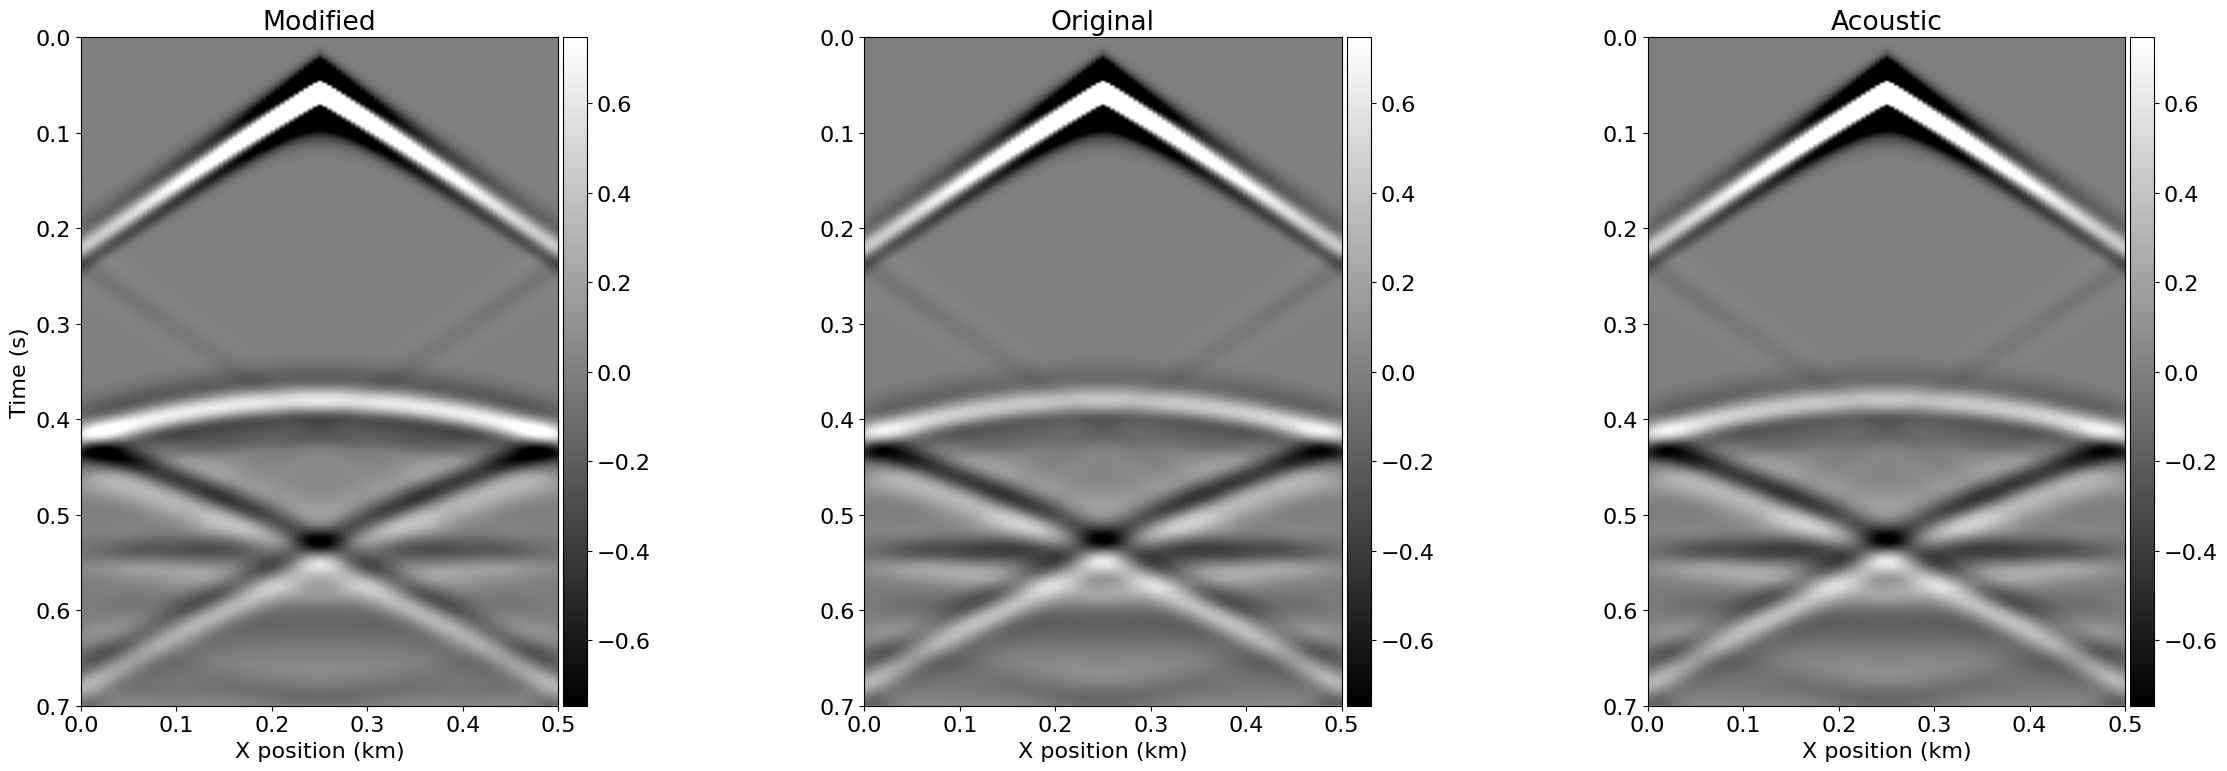

In [152]:
recs = [rec_modified.data, rec_original.data, rec_acoustic.data]
names = ['Modified', 'Original', 'Acoustic']

plot_data(recs, names, model, geometry.t0, geometry.tn)

In [153]:
def plot_trace(recs, labels, tr_idx, geometry, title='', start_idx = 0):
    t_axis = geometry.time_axis.time_values

    for i, rec in enumerate(recs):
        plt.plot(rec[start_idx:, tr_idx], t_axis[start_idx:], label=labels[i])

        plt.legend(fontsize='small')
        plt.title(title)
        plt.xlabel('Amplitude')
        plt.ylabel('Time (ms)')

        plt.grid()
    plt.gca().invert_yaxis()

    plt.show()

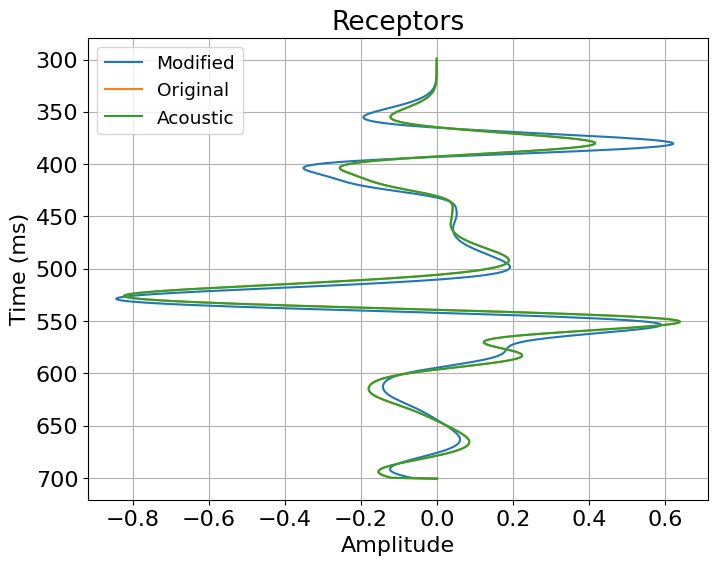

In [154]:
tr_idx = rec_modified.data.shape[1]//2
start_idx = 0
start_idx = int(300/geometry.dt)

plot_trace(recs, names, tr_idx, geometry, 'Receptors', start_idx=start_idx)

In [155]:
# recs = [rec_modified.data - rec_original.data]
# names = ['Modified - Original']

# plot_data([rec_modified.data - rec_original.data], ['Modified - Original'], model, geometry.t0, geometry.tn)

## Equation Deviation

In [156]:
def forward(model, geometry, src, rec, use_terms=[0,1,2,3,4]):
    u = TimeFunction(name='u', grid=model.grid, time_order=TIME_ORDER,
                            space_order=SPACE_ORDER)
    
    m = model.m
    r = model.r
    vp = model.vp
    dt = model.grid.stepping_dim.spacing

    terms = [
        m * u.dt2, 
        - 1/vp * div(vp*grad(u, .5), -.5), 
        2 * div(u * r, -.5),
        2 * u * div(-r, -.5),
        model.damp * u.dt
    ]

    pde = 0
    for i in use_terms:
        pde = terms[i] + pde

    stencil = [Eq(u.forward, solve(pde, u.forward))]

    src_term = src.inject(field=u.forward, expr=src * dt**2/model.m)
    rec_term = rec.interpolate(expr=u)

    op = Operator(stencil + src_term + rec_term, subs=model.spacing_map)
    op(dt=geometry.dt)
    
    return u, pde


def adjoint(model, geometry, rec, srca=None):
    v = TimeFunction(name='v', grid=model.grid, time_order=TIME_ORDER,
                    space_order=SPACE_ORDER)
    
    m = model.m
    vp = model.vp
    r = model.r
    dt = model.grid.stepping_dim.spacing

    pde = m * v.dt2 - div(vp * grad(v/vp, .5), -.5) - 2 * r.T * grad(v, .5)\
        - 2 * v * div(r, -.5) + model.damp * v.dt.T
    stencil = [Eq(v.backward, solve(pde, v.backward))]

    rec_term = rec.inject(v.backward, expr = rec * dt**2 / m)

    terms = stencil
    terms += rec_term

    if srca:
        srca_term = srca.interpolate(expr=v)
        terms += srca_term

    op = Operator(terms, subs=model.spacing_map)
    op(dt=geometry.dt)
    return v

L_selective_modified = OpWrapper(forward, adjoint)

In [157]:
src, rec_04 = src_rec(model, geometry, src_pos, rec_depth, nrec)
_, rec_014 = src_rec(model, geometry, src_pos, rec_depth, nrec)
_, rec_024 = src_rec(model, geometry, src_pos, rec_depth, nrec)
_, rec_034 = src_rec(model, geometry, src_pos, rec_depth, nrec)
_, rec_0124 = src_rec(model, geometry, src_pos, rec_depth, nrec)
_, rec_0234 = src_rec(model, geometry, src_pos, rec_depth, nrec)
_, rec_01234 = src_rec(model, geometry, src_pos, rec_depth, nrec)

In [158]:
_, pde04 = L_selective_modified(model, geometry, src, rec_04, use_terms=[0,4])
_, pde014 = L_selective_modified(model, geometry, src, rec_014, use_terms=[0,1,4])
_, pde024 = L_selective_modified(model, geometry, src, rec_024, use_terms=[0,2,4])
_, pde034 = L_selective_modified(model, geometry, src, rec_034, use_terms=[0,3,4])
_, pde0124 = L_selective_modified(model, geometry, src, rec_0124, use_terms=[0,1,2,4])
_, pde0234 = L_selective_modified(model, geometry, src, rec_0234, use_terms=[0,2,3,4])
_, pde01234 = L_selective_modified(model, geometry, src, rec_01234, use_terms=[0,1,2,3,4])

Operator `Kernel` ran in 0.02 s
Operator `Kernel` ran in 0.02 s
Operator `Kernel` ran in 0.04 s
Operator `Kernel` ran in 0.04 s
Operator `Kernel` ran in 0.04 s
Operator `Kernel` ran in 0.03 s
Operator `Kernel` ran in 0.04 s


In [159]:
test = Function(name='test', grid=model.grid, space_order=SPACE_ORDER)

Operator([Eq(test, model.m)])()

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=5.2e-05, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

In [160]:
def latex_print(symbol):
    return Latex(f'$${latex(symbol)}$$'.replace('frac', 'dfrac'))